# Barrents sea - Producer Notebook

## Introduction (TO EDIT)

**Goal: generate a temperature map at a given depth, and at a given time, and within given geographical boundaries!**


This Notebook provides guidance and support for data processing of CTD data, in particular by making use of the Geostatistical Library (RIntaros / RGeostats) for the modelisation of geostatistical relationships between variables, and to interpolate gridded data maps out of irregular CTD point measurements.

The CTD data access point is configured for the OPeNDAP Hyrax server operated by the Institute of Marine Research, Norwegian Marine Data Centre, Norway
http://opendap1.nodc.no/opendap/physics/point/yearly/contents.html

Note: for this server, the **.nc4** extension from the data access URLs is not supported.

The multi-year selection for CTD campaigns at sea is supported via the **year** parameter in the *fetch_data(url, year)* function in *helpers.py*, and consequently all the *fetch_data(url, year)* function calls within the Notebook. 

Citation: refer to the EC INTAROS project (https://cordis.europa.eu/project/id/727890).

# User-defined Input Parameters
These are the required input parameters that the user must define for the analysis, keeping in mind the goal of this notebook to **generate a temperature map at a given depth, and at a given time, and within given geographical boundaries**

## Import Libraries

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os

from helpers import *

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

from datetime import datetime, timedelta
import calendar

In [2]:
# Function to apply margin for extensions
margin = 20 # ie 20% of value
def applyMargin(value, f):
    """
    value: input value to apply the margin to
    f: flag, must be "low" or "high" for lower or higher boundary
    """
    if f == 'low': newvalue = value - (value * margin / 100)
    elif f == 'high': newvalue = value + (value * margin / 100)
    else: print('Wrong margin flag, must be "low" or "high".'); stop
    return newvalue

## Depth

In [3]:
# User-defined Depth
depth = 20

# Apply margins
depth1 = int(applyMargin(depth, f='low'))
depth2 = int(applyMargin(depth, f='high'))

# Display
print('User-defined Depth:', depth)
print(f'Depth range (including margins): {depth1} - {depth2}')

User-defined Depth: 20
Depth range (including margins): 16 - 24


## Bounding Box (BBOX)

In [4]:
# User-defined bbox label and boundaries
bbox_key = 'UserAOI' # bbox label
bbox_usr = [-5, 15, 53, 60] # bbox boundaries, in the format: minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80] 

# Apply margins
bbox0 = int(applyMargin(bbox_usr[0], f='low'))
bbox1 = int(applyMargin(bbox_usr[1], f='high'))
bbox2 = int(applyMargin(bbox_usr[2], f='low'))
bbox3 = int(applyMargin(bbox_usr[3], f='high'))
bbox_values = [bbox0, bbox1, bbox2, bbox3]
bbox_dict = {}
bbox_dict[bbox_key] = bbox_values

# Display
print(f"User-defined BBOX='{bbox_key}': {bbox_usr}")
print(f'BBOX range (including margins): {bbox_values}')

User-defined BBOX='UserAOI': [-5, 15, 53, 60]
BBOX range (including margins): [-4, 18, 42, 72]


## Time Range

In [5]:
# User-defined Month of interest start and end date in the format [day,month,year]
year = 2003
month = 2 # number of the month
assert month > 1 and month < 12, 'Month must be between 2-11, to include margin of same calendar year'

# Apply Margin
month1 = month - 1
month2 = month + 1

day_start = 1
day_end = calendar.monthrange(year, month2)[1] # only used for the last day of month

time_start = datetime(year, month1, day_start)
time_end = datetime(year, month2, day_end)

# Display
time_filter_str = f'{time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}'
print(f'User-defined Month: {datetime(year, month,1).strftime("%Y-%m")}')
print(f'Time range (including margins): {time_filter_str}')

User-defined Month: 2003-02
Time range (including margins): 2003-01-01 - 2003-03-31


## Mesh

In [6]:
# User-define mesh (in degrees, equal for both long and lat)
mesh = 1 

# Display
print(f'User-defined Mesh: {mesh} degree')

User-defined Mesh: 1 degree


# Extraction of NetCDF Data

## Exploratory Data Analysis

### Set-up

#### Server URL

In [7]:
# Define URL of Norwegian Marine Data Centre (NODC) data
nodc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' # on NODC server

server_url = nodc_url

#### Define Year and Platform Codes 
The information on **year** and **platforms** available on the server (the individual NetCDF files) must be known a priori 

In [8]:
platform_codes = ['AA', 'GS', 'GT', 'HJ', 'JH'] # Define codes of platforms of interest

### Retrieval of DDS info
Access data using the dds info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION'

In [9]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

for pc in platform_codes:
    
    dds = f'{server_url}/58{pc}_CTD_{year}.nc.dds'
        
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

#pprint.pprint(pc_dim_dict)
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


### Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

#### Create *position_dict*
This dictionary is used to store xarray data and attributes for the variables 'TIME', 'LATITUDE', 'LONGITUDE' of the point measurements of the available platforms.

In [10]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2003.nc?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2003.nc?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2003.nc?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


#### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**LONGITUDE** and **LATITUDE**) and respective **TIME** for all platforms, in order to plot and visualise them.

In [11]:
# Load locations (long & lat) and TIME of ALL measurements
start_date = datetime(1950, 1, 1)
    
position_df = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df = position_df.append(test) 
    
position_df['Index_ABS'] = np.arange(0,len(position_df))
position_df = position_df.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df)} measurement locations')
position_df

Platform AA: 684 measurement locations.


,Longitude,Latitude,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude,Latitude,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude,Latitude,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude,Latitude,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude,Latitude,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


#### Plot Histogram of measurements of the given year

<AxesSubplot:xlabel='Time'>

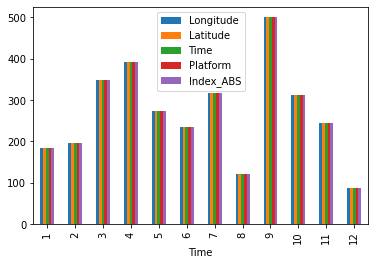

In [12]:
position_df.groupby(position_df["Time"].dt.month).count().plot(kind="bar")

#### Plot Positions
Plot locations on an interactive plot. Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [13]:
def plotIteractive(df2p, title, xlim, ylim, bbox=False):
    output_notebook() # necessary to show the plot 

    hover = HoverTool(
            tooltips=[
                ("index", "$index"),
                ("(x,y)", "($x, $y)"),
                ("Platform", "@Platform"),            
            ]
        )

    p = figure(plot_width=500, 
               plot_height=500, 
               tools=[hover],
               title=title,
               x_range=xlim, 
               y_range=ylim)

    # p.square('Longitude', 'Latitude', size=6, color='grey', fill_color='white', source=df2p, legend_label="All locations")
    if any(df2p['Platform']=='AA'): p.circle('Longitude', 'Latitude', size=4, color='red', fill_color='white', source=df2p[df2p['Platform']=='AA'], legend_label="Platform AA")
    if any(df2p['Platform']=='GS'): p.circle('Longitude', 'Latitude', size=4, color='blue', fill_color='white', source=df2p[df2p['Platform']=='GS'], legend_label="Platform GS")
    if any(df2p['Platform']=='GT'): p.circle('Longitude', 'Latitude', size=4, color='green', fill_color='white', source=df2p[df2p['Platform']=='GT'], legend_label="Platform GT")
    if any(df2p['Platform']=='HJ'): p.circle('Longitude', 'Latitude', size=4, color='black', fill_color='white', source=df2p[df2p['Platform']=='HJ'], legend_label="Platform HJ")
    if any(df2p['Platform']=='JH'): p.circle('Longitude', 'Latitude', size=4, color='orange', fill_color='white', source=df2p[df2p['Platform']=='JH'], legend_label="Platform JH")

    # Add area
    if bbox: 
        bbox_val = list(bbox_dict.values())[0]
        p.quad(left=bbox_val[0], right=bbox_val[1], top=bbox_val[3], bottom=bbox_val[2], 
               legend_label=list(bbox_dict.keys())[0], fill_color='grey', fill_alpha=0.0, line_color="black")

    p.legend.location = "bottom_right"
    show(p)

In [14]:
xlim = (min(position_df['Longitude'])-1, max(position_df['Longitude'])+1)
ylim = (min(position_df['Latitude'])-1, max(position_df['Latitude'])+1)

title = f'All measurement points'
plotIteractive(position_df, title, xlim, ylim, bbox=False)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the 'LATITUDE', 'LONGITUDE' and 'TIME' dimensions. First, the data is filtered by bounding box (BBOX). Subsequently, this data is further filtered using a time range.

#### Filter by BBOX

In [15]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox_values[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox_values[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox_values[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox_values[3])]

print(f'BBOX={bbox_key} range (including margins): {bbox_values}')
sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox)

title = f'Filtered data: BBOX={bbox_key}'
plotIteractive(position_df_bbox, title, xlim, ylim, bbox_dict)

BBOX=UserAOI range (including margins): [-4, 18, 42, 72]
Selected positions (out of available positions): 1745 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


Loading BokehJS ...

#### Filter by BBOX, adding Time Range filter

In [51]:
position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]

print(f'BBOX={bbox_key} range (including margins): {bbox_values}')
print(f'Time range (including margins): {time_filter_str}')
sel_outof_all = f'{len(position_df_bbox_timerange)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox_timerange)

title = f'Filtered data: BBOX={bbox_key} and Time={time_filter_str}'
plotIteractive(position_df_bbox_timerange, title, xlim, ylim, bbox_dict)

BBOX=UserAOI range (including margins): [-4, 18, 42, 72]
Time range (including margins): 2003-01-01 - 2003-03-31
Selected positions (out of available positions): 383 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
202,3.6540,63.072300,2003-03-25 00:24:29,JH,2461
203,3.3903,63.190300,2003-03-25 03:07:46,JH,2462
204,3.1247,63.307999,2003-03-25 05:10:42,JH,2463


Loading BokehJS ...

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [17]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None)
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

#### Define Filtered Dataframe (*df_toPlot*) to be used for online querying of the filtered positions
Define the filtered dataframe (eg *position_df_bbox*, *position_df_bbox_timerange*), to be named **df_toPlot**, and the dictionary of indices of filtered data (to be named **index_dict**), to use for further filtering.

In [18]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange # or position_df / position_df_bbox

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Filtered positions in "BBOX={bbox_key}" and "Time range={time_filter_str}" (out of available positions): {sel_outof_all}')

display(df_toPlot)

Filtered positions in "BBOX=UserAOI" and "Time range=2003-01-01 - 2003-03-31" (out of available positions): 383 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
202,3.6540,63.072300,2003-03-25 00:24:29,JH,2461
203,3.3903,63.190300,2003-03-25 03:07:46,JH,2462
204,3.1247,63.307999,2003-03-25 05:10:42,JH,2463


In [19]:
index_dict = {}

for pc in df_toPlot['Platform'].unique():
    index_dict[pc] = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

# index_dict

## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables accessing data of **only the selected variable** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Data Extraction

### Define Variables

In [20]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variable to use for the analysis
vars_sel = ['TEMP', 'CNDC', 'PSAL']; assert all([elem in vars_main for elem in vars_sel])

### Create **data_dict** dictionary 
Once variables are defined, the DEPTH range must be defined. 

**INSERT BELOW** the desired DEPTH range (in meters) in the two fields of hte following cell, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

Once the variables and DEPTH range are defined, data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

In [21]:
data_dict = {}
metadata = {}

for pc in df_toPlot['Platform'].unique():
    
    metadata[pc] = {}

    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 0
    metadata[pc]['depth_m_v2'] = depth2 #pc_dim_dict[pc]['DEPTH'] 
    # ==============================================================================

    # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

    #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

    metadata[pc]['depth_newindex4xr_v1'] = 0

    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for v in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)

    # Build url and url with queries (url_q)
    url = f'{server_url}{fix_lab}.nc?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

    remote_data, data_attr = fetch_data(url_q, year)

    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}

    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 24,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 24,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 24,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 24
Platform AA URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2003.nc?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:24],CNDC[0:1:683][0:1:24],PSAL[0:1:683][0:1:24]
['58AA' 'H\\303\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 2956,
 'depth_m_v1': 0,
 'depth_m_v2': 24,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 24,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 24,
 'vmin': 1}
GT DEPTH range of interest (adjusted with vmin): 0 - 24
Platform GT URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58GT_CTD_2003.nc?TIME[0:

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe overview_df is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [22]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\303\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [23]:
# Extract / define the variables to use for the analysis
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in data_dict.keys():
    print(f'{k}; Initial DEPTH range: {metadata[k]["depth_m_v1"]}-{metadata[k]["depth_m_v2"]}m; VARS: {list(data_dict[key]["data"].variables)}')


Printing DEPTH range for analyis:
AA; Initial DEPTH range: 0-24m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP', 'PSAL', 'CNDC']
GT; Initial DEPTH range: 0-24m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP', 'PSAL', 'CNDC']
JH; Initial DEPTH range: 0-24m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP', 'PSAL', 'CNDC']


In [24]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GT': {'TEMP': False, 'CNDC': False, 'PSAL': False},
 'JH': {'TEMP': False, 'CNDC': False, 'PSAL': False}}

### Data Filtering by DEPTH
This section allows adding the filter based on DEPTH on the previously filtered data (based on BBOX and time range).

The output of this operation is a *filtered_xarr* xarray dataset, containing one variable at the specified DEPTH range. 

#### Data filtered by DEPTH

In [25]:
filtered_xarr_dict = {}

for pc in data_dict.keys():
    
    # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False

    for v in vars_sel: 
        check_alignment(data_dict, pc, v, align_and_nan, vmin_dict)

    filtered_xarr_dict[pc] = filter_xarr_DEPTH(df_toPlot, 
                                               data_dict,
                                               platform=pc,
                                               depth_range=[depth1, depth2])
display(filtered_xarr_dict)

Platform: AA; Vertical min: 0.0; Var: TEMP
Platform: AA; Vertical min: 0.0; Var: CNDC
Platform: AA; Vertical min: 0.0; Var: PSAL
Platform: GT; Vertical min: 1.0; Var: TEMP --> aligning and add nan
Platform: GT; Vertical min: 1.0; Var: CNDC --> aligning and add nan
Platform: GT; Vertical min: 1.0; Var: PSAL --> aligning and add nan
Platform: JH; Vertical min: 1.0; Var: TEMP --> aligning and add nan
Platform: JH; Vertical min: 1.0; Var: CNDC --> aligning and add nan
Platform: JH; Vertical min: 1.0; Var: PSAL --> aligning and add nan


{'AA': <xarray.Dataset>
 Dimensions:    (DEPTH: 9, LATITUDE: 248, LONGITUDE: 248, TIME: 248)
 Coordinates:
   * TIME       (TIME) float64 1.936e+04 1.936e+04 ... 1.943e+04 1.943e+04
   * LATITUDE   (LATITUDE) float32 60.76 60.75 60.75 60.75 ... 54.5 54.5 54.5
   * LONGITUDE  (LONGITUDE) float32 4.615 4.448 4.285 4.117 ... 2.704 2.116 1.539
 Dimensions without coordinates: DEPTH
 Data variables:
     TEMP       (TIME, DEPTH) float64 6.822 6.803 6.783 ... 6.377 6.376 6.376
     PSAL       (TIME, DEPTH) float64 34.04 34.03 34.03 ... 34.62 34.62 34.62
     CNDC       (TIME, DEPTH) float64 34.26 34.23 34.21 ... 34.38 34.38 34.38
 Attributes: (12/132)
     _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
     title:                          Arctic Ocean - In Situ Observation Copern...
     qc_manual:                      Recommendations for in-situ data Near Rea...
     contact:                        cmems-service@imr.no
     format_version:                 1.4
 

### Aggregation of Available Platforms
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. First check the dimensions of DEPTH are the same.

In [26]:
# Dictionary of variables for each platform
data_var_dict = {}
depth_arr = []

for pc in data_dict.keys():
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    depth_dim_pc = data.dims["DEPTH"]
    depth_arr.append(depth_dim_pc)
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')
    
    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]
        
assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
# display(data_var_dict)

PC AA	Filtered Dims: TIME=248, DEPTH=9
PC GT	Filtered Dims: TIME=108, DEPTH=9
PC JH	Filtered Dims: TIME=27, DEPTH=9


Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

{'TEMP': <xarray.Dataset>
 Dimensions:  (DEPTH: 9, TIME: 383)
 Coordinates:
   * TIME     (TIME) float64 1.936e+04 1.936e+04 ... 1.945e+04 1.945e+04
 Dimensions without coordinates: DEPTH
 Data variables:
     TEMP     (TIME, DEPTH) float64 6.822 6.803 6.783 6.793 ... 4.52 4.531 4.586
 Attributes:
     standard_name:        sea_water_temperature
     long_name:            Sea temperature
     units:                degrees_C
     valid_min:            -2500
     valid_max:            40000
     ancillary_variables:  TEMP_QC TEMP_DM
     data_mode:            M,
 'CNDC': <xarray.Dataset>
 Dimensions:  (DEPTH: 9, TIME: 383)
 Coordinates:
   * TIME     (TIME) float64 1.936e+04 1.936e+04 ... 1.945e+04 1.945e+04
 Dimensions without coordinates: DEPTH
 Data variables:
     CNDC     (TIME, DEPTH) float64 34.26 34.23 34.21 34.23 ... 32.03 32.04 32.11
 Attributes:
     standard_name:        sea_water_electrical_conductivity
     long_name:            Electrical conductivity
     units:          

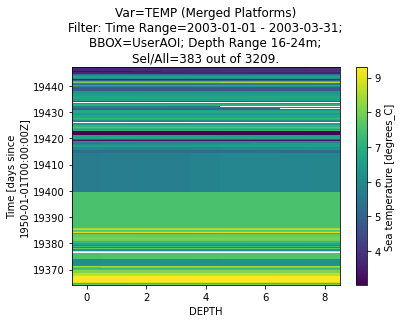

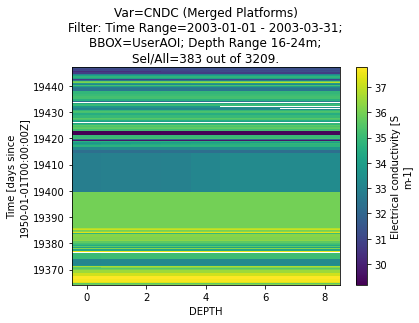

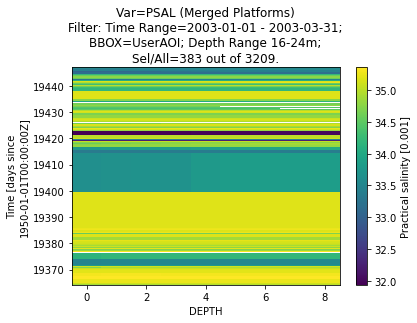

In [27]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
        
    merged_arr[var] = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys()])  
        
    title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_filter_str};\nBBOX={bbox_key}; Depth Range {depth1}-{depth2}m;\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)
display(merged_arr)

### Create Dataframe of Filtered XARRAY
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file expected by the RGeostats module.


In [63]:
start_date

datetime.datetime(1950, 1, 1, 0, 0)

In [64]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 
        
        # Convert Time from float to datetime
        temp['Time'] = [start_date + timedelta(t) for t in temp.loc[:,'Time']]
        
        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vaissel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Conductivity,Salinity,Depth,Vaissel_name
rank,,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,6.822,34.255,34.036,16,AA
1,4.4483,60.748299,2003-01-07 06:05:08,6.808,34.555,34.382,16,AA
2,4.2853,60.751499,2003-01-07 08:34:00,7.760,35.885,34.882,16,AA
3,4.1170,60.747799,2003-01-07 09:18:06,7.522,35.358,34.548,16,AA
4,3.9475,60.752201,2003-01-07 09:59:37,6.778,34.365,34.202,16,AA
...,...,...,...,...,...,...,...,...
3442,3.6540,63.072300,2003-03-25 00:24:29,8.375,36.866,35.315,24,JH
3443,3.3903,63.190300,2003-03-25 03:07:46,8.278,36.755,35.293,24,JH
3444,3.1247,63.307999,2003-03-25 05:10:42,8.475,36.892,35.242,24,JH


### Assign *Profil_id* to the unique positions

In [65]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Conductivity,Salinity,Depth,Vaissel_name,Profil_id
rank,,,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,6.822,34.255,34.036,16,AA,198
1,4.4483,60.748299,2003-01-07 06:05:08,6.808,34.555,34.382,16,AA,191
2,4.2853,60.751499,2003-01-07 08:34:00,7.760,35.885,34.882,16,AA,184
3,4.1170,60.747799,2003-01-07 09:18:06,7.522,35.358,34.548,16,AA,177
4,3.9475,60.752201,2003-01-07 09:59:37,6.778,34.365,34.202,16,AA,173
...,...,...,...,...,...,...,...,...,...
3442,3.6540,63.072300,2003-03-25 00:24:29,8.375,36.866,35.315,24,JH,157
3443,3.3903,63.190300,2003-03-25 03:07:46,8.278,36.755,35.293,24,JH,148
3444,3.1247,63.307999,2003-03-25 05:10:42,8.475,36.892,35.242,24,JH,136


#### Plot Histogram of measurements of the given year

<AxesSubplot:xlabel='Month & Day', ylabel='Count'>

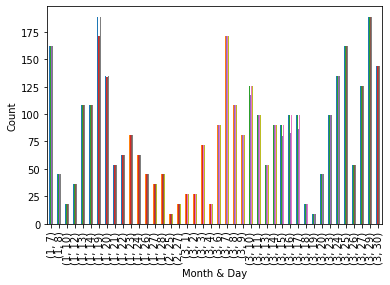

In [74]:
filtered2csv_multiDepths.groupby([filtered2csv_multiDepths["Time"].dt.month,
                                  filtered2csv_multiDepths["Time"].dt.day]).count().plot(kind="bar", 
                                                                                         legend=False, 
                                                                                         xlabel='Month & Day',
                                                                                         ylabel='Count')

### Export to CSV

In [30]:
# Save dataframe to csv
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)

csvname = os.path.join(data_output, 
                       f'filtered_BBOX={bbox_key}_MMYYYY={str(month).zfill(2)}{year}_\
                       Depth={depth1}-{depth2}m_VARS={"_".join(vars_sel)}.csv')

filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)

# Geostatistical Analysis with RGeostats
## Set-up

### Install R Kernel & Testing

In [31]:
!pip install rpy2

%load_ext rpy2.ipython

### Import variables from Python

In [32]:
import rpy2.robjects as robjects

# BBOX (note it's stored as an array of format: [minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80]]
robjects.globalenv['bbox_key'] = bbox_key
robjects.globalenv['long_min'] = bbox_values[0]
robjects.globalenv['long_max'] = bbox_values[1]
robjects.globalenv['lat_min'] = bbox_values[2]
robjects.globalenv['lat_max'] = bbox_values[3]

# Time Range
robjects.globalenv['time_filter_str'] = time_filter_str

# Depth Range
robjects.globalenv['depth'] = depth
robjects.globalenv['depth1'] = depth1
robjects.globalenv['depth2'] = depth2

# Mesh
robjects.globalenv['mesh'] = mesh

# Directory and CSV Name
robjects.globalenv['data_output'] = data_output 
robjects.globalenv['csvname'] = csvname

# Variables
robjects.globalenv['vars'] = '_'.join(vars_sel) 

In [36]:
%%R
# Check Variables
print('Printing variables imported from Python script')
cat('bbox_key:', bbox_key, '\n')
long_lim   = c(long_min, long_max)
lat_lim    = c(lat_min, lat_max)
cat('long_lim:', long_lim, '\n')
cat('lat_lim:', lat_lim, '\n')
cat('time_filter_str:', time_filter_str, '\n')
cat('depth:', depth, '\n')
cat('depth1:', depth1, '\n')
cat('depth2:', depth2, '\n')
cat('mesh:', mesh, '\n')
cat('data_output:', data_output, '\n')
cat('csvname:', csvname, '\n')
cat('vars:', vars, '\n')

[1] "Printing variables imported from Python script"
bbox_key: UserAOI 
long_lim: -4 18 
lat_lim: 42 72 
time_filter_str: 2003-01-01 - 2003-03-31 
depth: 20 
depth1: 16 
depth2: 24 
mesh: 1 
data_output: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output 
csvname: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/filtered_BBOX=UserAOI_MMYYYY=022003_                       Depth=16-24m_VARS=TEMP_CNDC_PSAL.csv 
vars: TEMP_CNDC_PSAL 


## Definition of the environment

The next cells have specific contents for loading the library **RIntaros** that the user must choose to run or to skip. Their order is important.

In [38]:
%%R 
suppressWarnings(suppressPackageStartupMessages(library(RIntaros)))

# Defining if the data set must be read or not from the CSV (flag.read)
flag.read = FALSE

## Loading Data

First of all, we setup some environment variables (data file name and bounding box).
The **flag_file** allows the user to store each generated graphic file as a **PNG** file in the **image_name** directory, instead of plotting them.

In [49]:
%%R 
# Setup OUR environment and datasets 
dir.name   = getwd()
data.name  = basename(data_output)
file.name  = basename(csvname)

intaros.save.environ(long_lim = long_lim, lat_lim = lat_lim,
                     flag_file = FALSE)

var = "Temperature"

Then we read the **CSV** file (taking the header line into account) and create the RGeostats Db. Finally we show the contents of the newly created Db (named **db0**).

In [50]:
%%R 
if (flag.read || ! exists("db0")) db0 = imr_read_csv(file.path(dir.name,data.name,file.name))
db0


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of fields             = 9
Maximum Number of attributes = 9
Total number of samples      = 3447

Variables
---------
Field =   1 - Name    =  rank - Locator =  NA
Field =   2 - Name    =  Longitude - Locator =  x1
Field =   3 - Name    =  Latitude - Locator =  x2
Field =   4 - Name    =  Time - Locator =  NA
Field =   5 - Name    =  Temperature - Locator =  NA
Field =   6 - Name    =  Conductivity - Locator =  NA
Field =   7 - Name    =  Salinity - Locator =  NA
Field =   8 - Name    =  Depth - Locator =  NA
Field =   9 - Name    =  Profil_id - Locator =  NA


## Dataset global statistics

We first establish the time amplitude of the dataset, as well as a set of colors assigned to each year.

In [53]:
%%R
years      = subyears = get_db_limits_year(db0)
colyears   = rg.colors(length(years))
cat(build_title("The dataset period is:",time2date(get_db_limits_time(db0))))

The dataset period is: (2003-01-07 => 2003-03-30)

Let us get some statistics on the information available

In [54]:
%%R
db.stat.print(db0,funs=c("num","mini","maxi","mean"),
              names=c("Longitude","Latitude","Depth","Temperature"))#,"Conductivity","Salinity"))

               Number   Minimum   Maximum      Mean
Longitude        3447    -2.236    17.889     6.338
Latitude         3447    53.996    71.841    61.436
Depth            3447    16.000    24.000    20.000
Temperature      3380     3.033     9.292     6.380



### Studying Temperature variable

From this point, most of the calculations will be performed based on the **Temperature** variable.

#### All Database

We display all samples focusing on the variable in a 2D aerial view, reporting the country borders. For comparison, we define a common color scale, established on the global minimum and maximum values (**var_scale0**).
Note that all samples from all years and all depths are displayed (slow operation).

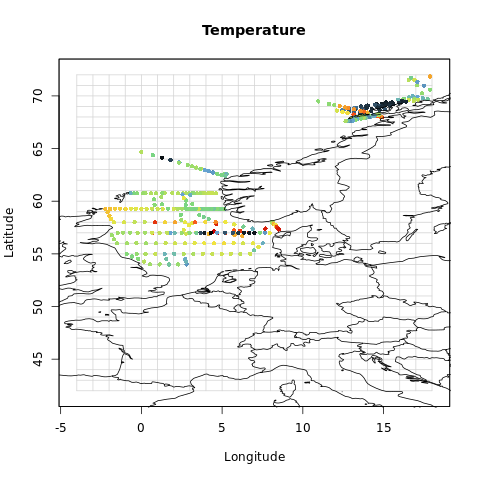

In [55]:
%%R
colors.temp = rg.colors(rank=1)
var_scale0 = get_db_limits_var(db0,var)
display_var(db0, var = var, colors = colors.temp, title = var, filename = var)

### Block Average at the given Depth

The next display considers the variable averaged over the cells of a coarse grid (mesh of 1 degree).

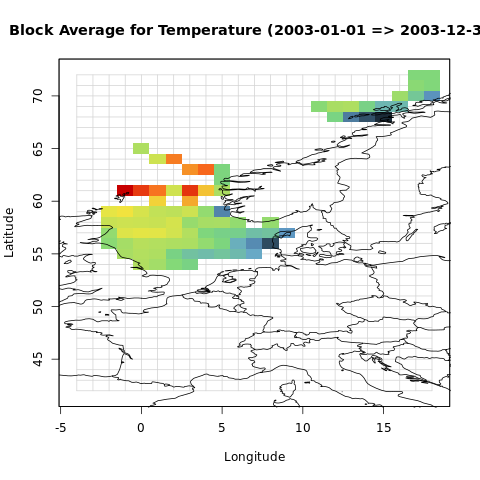

In [56]:
%%R
var = "Temperature"

# Select samples and set the color scale
db1       = apply_sel(db0, depth_lim=c(depth1,depth2),compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following line if you want to to display all years
subyears = years[1]

date_lim  = create_limits_date(years[1])
db        = apply_sel(db1, date_lim=date_lim)
filename  = paste0(var,"_Mean_",years[1])
title     = paste("Block Average for", build_title(var, date_lim))
dbg       = stats_grid(db, var, fun = "mean", mesh = 1)
display_stats(dbg, var, var_scale = var_scale, colors = colors.temp,
            title = title, filename = filename)

## Import in RGeostats database structure

### Histogram of Measurement Depths

We also aggregate the values of all samples vertically from 0m to 100m by 10 steps of 10m.
Then, we can double-check this regularization step by plotting the histogram of the initial depths and the histogram of the depths in the aggregated file.

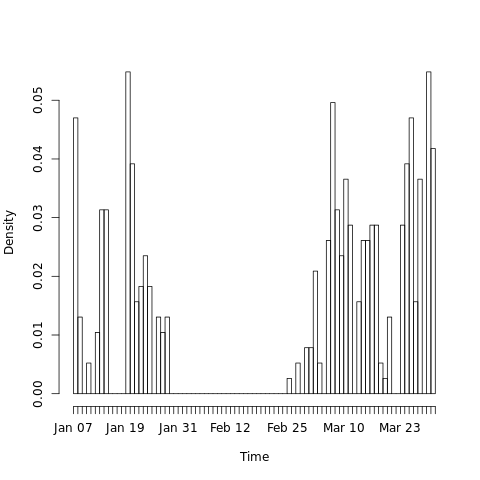

In [60]:
%%R
# Histogram of depths
hist(time2date(db0[,"Time"]),breaks=100,xlab="Time",main="")

## Horizontal Variogram per Year

Review the horizontal variograms for different years at 25m depth, calculated from the aggregated data set.

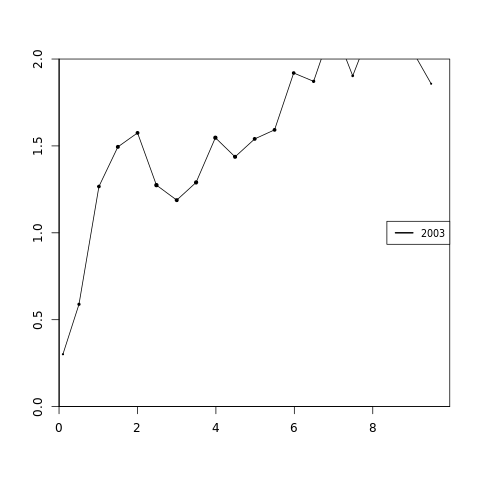

In [59]:
%%R
# Define the active samples
depth_lim = c(depth1,depth2)
dbr       = db.locate(db0,var,"z")

# Variogram parameters
vario_lag  = 0.5
vario_nlag = 20
varmax = 2

# Loop on the years
ecr = 1
add = FALSE
for (year in years) 
{
  date_lim = create_limits_date(year)
  dbr = remove_sel(dbr)
  dbr = apply_sel(dbr, date_lim = date_lim)

  vario = prepar_vario(dbr, dirvect=NA, 
                       vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario=TRUE,
                       add=add, ylim=c(0,varmax), col=colyears[ecr], lwd=1,
                       varline=FALSE, npairdw=TRUE)

  ecr = ecr + 1
  add = TRUE
}
legend("right",legend=years,col=colyears,lty=1,lwd=2,cex=0.8)

## Cross-Validation

We first perform a cross-validation step

In [ ]:
%%R 
# Define the active samples
depth_lim = c(depth1,depth2)
date_lim  = create_limits_date(year) 

# Variogram parameters
vario_lag  = 0.5
vario_nlag = 20

# Perform the Cross-validation (includes Variogram calculation and Model fitting)
dbp = xvalid_2D(dbr, var,  
                vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                dirvect = NA, draw.model=TRUE, radix="Xvalid")
db.stat.print(dbp,names="Xvalid*",funs=c("num","mean","var"),title="Cross-Validation Scores")

# Display the results
filename  = paste0("Xvalid_",var)
display_var(dbp, var = "*stderr", flag.xvalid = TRUE,
            title = paste(var, 'Cross-Validation Standard Error'), filename = filename, pos.legend=7)

## 2-D Estimation of Temperature

We interpolate the Temperature for the given bounding box, at the given depth, and given time interval.

In [ ]:
%%R 
# Select the active samples
depth = 10

# Variogram parameters
vario_lag  = 0.5
vario_nlag = 20

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(db0, var, mesh = 0.1, moving=FALSE,
                     vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                     dirvect = NA, draw.model=TRUE, pos.legend=1)

# Display the results
filename  = paste0(var,".Estim2D_Year_",year)
display_result(db0, dbg, var = var, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, filename = filename, pos.legend=7)